# Review DPS outputs
Make a mosaic of DPS outputs.

1. make a list of the DPS output paths with build_tindex.master.py
2. Identify duplicate tiles
3. Identify matching tiles; merge tindex.master with the original index tile file
4. make mosaicjson
5. View DPS results

In [1]:
import geopandas
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import maplib_folium
def local_to_s3(url, user = 'nathanmthomas', type='public'):
    ''' A Function to convert local paths to s3 urls'''
    if type is 'public':
        replacement_str = f's3://maap-ops-workspace/shared/{user}'
    else:
        replacement_str = f's3://maap-ops-workspace/{user}'
    return url.replace(f'/projects/my-{type}-bucket', replacement_str)

!pip install -U -r '/projects/Developer/icesat2_boreal/dps/requirements_main.txt'
!pip install pystac

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Choose a DPS data type; get its tile index master file
Get a filename of the master list DPS output tiles returned with _build_tindexmaster.py

In [2]:
DPS_DATA_TYPE = 'HLS' #"Topo" "Landsat" "ATL08" "ATL08_filt" "AGB"
DPS_DATA_USER = 'nathanmthomas' #'nathanmthomas' 'lduncanson'
TEST_HLS = True
DPS = True

if TEST_HLS:
    # Run tests on set of NORWAY + AK + MISC or any other tiles of interest in DPS_mscomp nb
    # misc tests 
    #NAME_HLS_TEST = 'test_mc0_3yrs'
    #NAME_HLS_TEST = 'test_single_years'
    #NAME_HLS_TEST = '03'
    #DAY_START_TEST = 24    
    
    # better tests
    NAME_HLS_TEST = 'test_mc10_3yrs'
    DAY_START_TEST = 23
    NAME_HLS_TEST = '03'#'test_mc40_3yrs'
    DAY_START_TEST = 24
    
    ENDSTR = '.tif'
    if DPS:
        OUT_MASTER_CSV_JSON_DIR = f's3://maap-ops-workspace/{DPS_DATA_USER}/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/{NAME_HLS_TEST}'  #LOCAL_WRITE_DIR = f'/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/{NAME_HLS_TEST}'
        !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m $NAME_HLS_TEST -d_min $DAY_START_TEST -o $OUT_MASTER_CSV_JSON_DIR --ends_with_str $ENDSTR
    else:
        LOCAL_DIR_PART = f'shared/nathanmthomas/test_hls/{NAME_HLS_TEST}'
        OUT_MASTER_CSV_JSON_DIR = f'/projects/my-public-bucket/test_hls/{NAME_HLS_TEST}'
        !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS --LOCAL_TEST -local_dir $LOCAL_DIR_PART -o $OUT_MASTER_CSV_JSON_DIR --ends_with_str $ENDSTR
else:
    #OUT_MASTER_CSV_JSON_DIR = f'/projects/shared-buckets/{DPS_DATA_USER}/DPS_tile_lists'
    OUT_MASTER_CSV_JSON_DIR = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists'
    #!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03 -d_min 23

tindex_master_fn        = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.csv')
tile_matches_geojson_fn = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.json') 
out_mosaic_json_fn      = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master_mosaic.json') 
    
#tindex_master_fn = '/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/run_LC_height_thresholds/ATL08_filt_tindex_master.csv'

#Get other tile index master files
ATL08_filt_sample_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_sample_tindex_master.csv'
#ATL08_filt_tindex_master_fn       = '/projects/test_dps/ATL08_filt_tindex_master.csv'#'s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_tindex_master.csv'
ATL08_filt_tindex_master_fn        = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_tindex_master.csv'
Topo_tindex_master_fn              = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv'

Topo_tindex_master                 =  pd.read_csv(Topo_tindex_master_fn)
ATL08_filt_tindex_master           =  pd.read_csv(ATL08_filt_tindex_master_fn)
ATL08_filt_sample_tindex_master    =  pd.read_csv(ATL08_filt_sample_tindex_master_fn)



/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		03
Days:		24-31

Output dir:  s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_7_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_178_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3848_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/

In [3]:
print(f"python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m {NAME_HLS_TEST} -d_min {DAY_START_TEST} -o {OUT_MASTER_CSV_JSON_DIR} --ends_with_str {ENDSTR}")

python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03 -d_min 24 -o s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03 --ends_with_str .tif


In [4]:
UPDATE_TINDEX = False

if not os.path.isfile(tindex_master_fn):
     UPDATE_TINDEX = True
else:
    print('Using existing tindex')
    print(tindex_master_fn)

    
if UPDATE_TINDEX:
    print(f"Building master tile index for: {DPS_DATA_TYPE}")
    dps_month = 'run_LC_height_thresholds'
    d_min = 1
    #os.system(f"python /projects/icesat2_boreal/lib/build_tindex_master.py --type {DPS_DATA_TYPE} -m {dps_month} -d_min {d_min}")
    !python /projects/icesat2_boreal/lib/build_tindex_master_v2.py --type $DPS_DATA_TYPE -m $dps_month -d_min $d_min


Building master tile index for: HLS
python: can't open file '/projects/icesat2_boreal/lib/build_tindex_master_v2.py': [Errno 2] No such file or directory


### Get the tiles needed for the data of interest

In [5]:
# Build up a dataframe from the list of dps output files
tindex_master = pd.read_csv(tindex_master_fn)

if DPS_DATA_TYPE == 'Landsat' or DPS_DATA_TYPE == 'HLS' or DPS_DATA_TYPE == 'Topo':
    DPS_DATA_USER = 'nathanmthomas'
    
tindex_master['s3'] = [local_to_s3(local_path, user=DPS_DATA_USER, type = 'private') for local_path in tindex_master['local_path']]
print(f"# of expected {DPS_DATA_TYPE} tiles:\t\t\t\t\t\t{len(tindex_master)}")

# Wherever there is a 90k Topo tile, there should be data...
# Get all covar tiles that should account for the set of output we want
tiles_covars = pd.read_csv(Topo_tindex_master_fn).tile_num
print(f"# of expected covar (from Topo) tiles:\t\t\t\t\t{len(tiles_covars)}")

# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)
#boreal_tile_index.astype({'layer':'int'})
#boreal_tile_index.rename(columns={"layer":"tile_num"}, inplace=True)
boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.
# For some reason, doing this causes 'MosaicJSON.from_features()' to fail...(below)
if True:
    # Remove bad tiles
    boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]
    
    
select_needs = [3360,2994,3190,2840,3012,3014,3017,2932,1261,1263,1264,988,978,794, 380,378,411,821,861,
                812,765,764,1308,1302,1469,1406,2495,2883,2965,3321,3509,3510,3327,3335,2976,2906,2907,2894,2814,4253,4293,4403,4440,4408,4372,4477,3986]
tile_matches_select_needs = boreal_tile_index.merge(ATL08_filt_tindex_master[ATL08_filt_tindex_master['tile_num'].isin(select_needs)], how='right', on='tile_num')
print(f"# of {DPS_DATA_TYPE} tiles needed (compared with {os.path.basename(ATL08_filt_tindex_master_fn)}):\t{len(tile_matches_select_needs)}")

print(f"# of total tiles supposedly needed (from {os.path.basename(boreal_tile_index_path)}):\t{len(boreal_tile_index)}")

if len(tile_matches_select_needs)<100:
    print([t for t in tile_matches_select_needs.tile_num])


# of expected HLS tiles:						57
# of expected covar (from Topo) tiles:					5072
# of HLS tiles needed (compared with ATL08_filt_tindex_master.csv):	0
# of total tiles supposedly needed (from boreal_tiles_v003.gpkg):	5190
[]


### Identify duplicate tiles

In [6]:
duplicate_tiles = [item for item, count in collections.Counter(tindex_master["tile_num"]).items() if count > 1]
print(duplicate_tiles)

[]


### Identify completed, missing, failed, & duplicate tiles

Tile status report for HLS from s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv:
	# tiles matched:		5190
	# tiles missing:		124
	# tiles duplicated: 		0
Missing tiles:	[4096, 2, 3, 7, 8, 1547, 15, 529, 530, 22, 2584, 2585, 33, 4134, 44, 569, 66, 1602, 1603, 4163, 4165, 4164, 4171, 4173, 4174, 96, 4198, 4199, 4201, 115, 1658, 4226, 135, 651, 652, 4247, 4248, 4253, 4258, 4269, 4270, 1715, 1716, 695, 696, 4289, 4290, 4291, 4292, 4301, 4309, 740, 4327, 4328, 3824, 4337, 4338, 1781, 4362, 4363, 4364, 4365, 276, 4375, 302, 4400, 4401, 4412, 4413, 4419, 329, 330, 3917, 4437, 4438, 3935, 3936, 3937, 3938, 358, 364, 4471, 4472, 4473, 4481, 389, 4487, 395, 3983, 4504, 4511, 4512, 4515, 420, 4005, 4516, 4517, 4522, 4523, 4524, 4530, 4531, 4532, 4021, 4022, 4539, 4544, 450, 451, 452, 453, 454, 4549, 4550, 4556, 4557, 1490, 4060, 4063, 4064, 4065, 489, 490, 4095]
Bad tiles:	[3540, 3634, 3728, 3823, 3916, 4004]


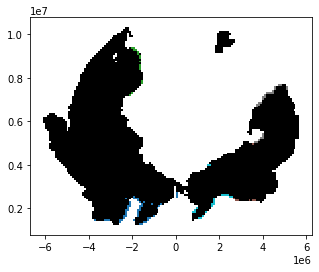

In [7]:
print(f"Tile status report for {DPS_DATA_TYPE} from {tindex_master_fn}:")
# For the tindex_master, convert it into vector tiles that show the tiles we have
# Select the rows we have results for
tile_index_matches = boreal_tile_index.merge(tindex_master[~tindex_master['tile_num'].isin(bad_tiles)][['tile_num','s3_path','local_path']], how='left', on='tile_num')
#tile_matches_atl08_filt_samples = boreal_tile_index.merge(ATL08_filt_sample_tindex_master[~ATL08_filt_sample_tindex_master['tile_num'].isin(bad_tiles)], how='right', on='tile_num')
print(f'\t# tiles matched:\t\t{len(tile_index_matches)}')

# Use the Topo tiles (COVAR set) to get the diff of what tiles we have and what we want
# MISSING TILES = DIFF(tiles_we_want, tiles_we_have)
#tile_nums_missing = np.setdiff1d(tiles_covars, tile_index_matches.tile_num)
tile_nums_missing_list = list(set(tiles_covars) - set(tile_index_matches.tile_num))
tile_nums_missing_list = list(set(tile_index_matches.tile_num) - set(tiles_covars))
# The ATL08 tiles we have may not exactly match the set of COVAR tiles we have
# Use the set of ATL08 tiles we have, crossed with the tiles we're missing (based on COVAR set), to get tiles we're missing that we should definitely proces (b/c we have both COVAR and ATL08 tiles for them)
#tile_index_missing = boreal_tile_index.merge(boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_nums_missing_list)], how='right', on='tile_num')
#tile_index_missing = boreal_tile_index.merge(tindex_master[tindex_master['tile_num'].isin(tile_nums_missing_list)], how='inner', on='tile_num')
tile_index_missing = boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_nums_missing_list)]

print(f'\t# tiles missing:\t\t{len(tile_index_missing)}')
tile_index_missing.to_file(f'/projects/my-public-bucket/DPS_tile_lists/Need_{DPS_DATA_TYPE}_tindex_master.gpkg', driver='GPKG')
#print(tile_index_missing.head())

# Meh, this doesnt give us fails
#tile_matches_failed = boreal_tile_index.merge(Topo_tindex_master[Topo_tindex_master['tile_num'].isin(tile_nums_missing)], how='right', on='tile_num')
#print(f'Missing b/c failed: \t{len(tile_matches_failed)}')

# Duplicates are also removed in build_tindex_master
tile_matches_duplicates = boreal_tile_index.merge(tiles_covars[tiles_covars.isin(duplicate_tiles)], how='right', on='tile_num')
print(f'\t# tiles duplicated: \t\t{len(tile_matches_duplicates)}')

# Drop duplicates
tile_index_matches = tile_index_matches.drop_duplicates(subset=['tile_num'], keep='last')
print(f"Missing tiles:\t{tile_nums_missing_list}")
print(f"Bad tiles:\t{bad_tiles}")

ax = tile_index_matches.plot(color='black')
tile_index_missing.plot(column='tile_group', ax=ax)


In [8]:
if 's3_path' in tile_index_matches.columns:
    tile_index_matches['s3'] = tile_index_matches['s3_path']
    
tile_index_matches = tile_index_matches[tile_index_matches['s3'].notna()]
tile_index_matches.head()

,tile_num,tile_version,tile_group,map_version,geometry,s3_path,local_path,s3
3,4,version 1,eurasia west,None,"POLYGON ((-2241478.000 9333304.000, -2151478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,s3://maap-ops-workspace/nathanmthomas/dps_outp...
6,7,version 1,eurasia west,None,"POLYGON ((-1971478.000 9333304.000, -1881478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,s3://maap-ops-workspace/nathanmthomas/dps_outp...
11,12,version 1,eurasia west,None,"POLYGON ((-2061478.000 9243304.000, -1971478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,s3://maap-ops-workspace/nathanmthomas/dps_outp...
13,14,version 1,eurasia west,None,"POLYGON ((-1881478.000 9243304.000, -1791478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,s3://maap-ops-workspace/nathanmthomas/dps_outp...
16,17,version 1,eurasia west,None,"POLYGON ((-2241478.000 9153304.000, -2151478.0...",s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,s3://maap-ops-workspace/nathanmthomas/dps_outp...


## Build a MosaicJSON

##### Build tile geojsons needed for mosaic jsons

In [9]:
tile_matches_geojson_string = tile_index_matches.to_crs("EPSG:4326").to_json()
tile_matches_geojson = json.loads(tile_matches_geojson_string)
#Write copy to disk for debug
#tile_matches_geojson_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master.json' 
tile_index_matches.to_file(tile_matches_geojson_fn, driver='GeoJSON')

if len(tile_index_missing) > 0:
    tile_index_missing_geojson_string = tile_index_missing.to_crs("EPSG:4326").to_json()
    tile_index_missing_geojson = json.loads(tile_index_missing_geojson_string)


In [10]:
from typing import Dict

from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

def get_accessor(feature: Dict):
    """Return specific feature identifier."""
    return feature["properties"]["s3"]

#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 
##out_mosaic_json_fn = f's3://maap-ops-workspace/shared/alexdevseed/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 

print(f"Building {out_mosaic_json_fn}")
mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

with MosaicBackend(out_mosaic_json_fn, mosaic_def=mosaicdata) as mosaic:
    mosaic.write(overwrite=True)

Building s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master_mosaic.json


## View the Results with Folium

In [11]:
from folium import Map, TileLayer, GeoJson, LayerControl, Icon, Marker, features, Figure, CircleMarker
from folium import plugins

# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

import branca.colormap as cm
import matplotlib.cm
pal_height_cmap = cm.LinearColormap(colors = ['black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850'], vmin=0, vmax=10)
pal_height_cmap.caption = 'Vegetation height from  ATL08 @ 30 m (h_can; rh98)'
#pal_height_cmap

dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = geopandas.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index
dem_tiles_index.to_file('/projects/my-public-bucket/dem30m_tiles_v2.geojson')

In [ ]:
maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, DPS_DATA_TYPE, boreal_tile_index, tile_index_matches, tile_index_missing, 
                              mosaic_json_dict = {
                                        'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master_mosaic.json',
                                        'topo_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json',
                                        'mscomp_mosaic_json_s3_fn': out_mosaic_json_fn #'s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master_mosaic.json'
                                    },
                             MS_BANDMAX=.5,
                             MS_BANDNUM=4,
                             MS_BANDCOLORBAR='hot'
                             )

In [ ]:
maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, DPS_DATA_TYPE, dem_tiles_index, tile_index_matches, tile_index_missing, 
                              mosaic_json_dict = {
                                        'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master_mosaic.json',
                                        'topo_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json',
                                        'mscomp_mosaic_json_s3_fn': out_mosaic_json_fn #'s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master_mosaic.json'
                                    },
                             MS_BANDMAX=1,
                             MS_BANDNUM=7,
                             MS_BANDCOLORBAR='viridis'
                             )

In [ ]:
maplib_folium.map_tile_n_obs(tindex_master_fn='s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_tindex_master.csv', 
                   map_name = '# of filtered ATL08 obs. from night & day', max_n_obs=15000)

In [ ]:
maplib_folium.map_tile_n_obs(tindex_master_fn='s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_sample_tindex_master.csv', 
                   map_name = '# of samples of filtered ATL08 obs. from night', max_n_obs=250)

In [ ]:
maplib_folium.map_tile_atl08(2804, DO_NIGHT=True)